# Make LASP2 mEos PERPL analysis plots

## Imports

In [2]:
import numpy as np
import modelling_general
import plotting
import zdisk_modelling
import zdisk_plots
import matplotlib.pyplot as plt

## Set average estimated localisation precision for Affimer and PALM data.
This is the mean after filtering for localisation precision < 5 nm.

In [2]:
meos_precision = 3.4 # Mean value after filtering for precision < 5 nm

## Set standard maximum distance over which to plot distances and fit models.

In [3]:
fitlength = 100.

## Choose Affimer relative position data and combine files if necessary
### Insert paths to the Affimer relative position data here:

In [5]:
meos_lasp_relpos_path = r'../perpl_test_data/mEos3-LASP2_PERPL-relpos_200.0filter_5FOVs_aligned_len533140.pkl'

### Select desired datasets to combine here:
These contain all data attributes, including the relative positions in both directions for each pair of localisations. We will filter e.g. for cell-axial data later.

In [6]:
path_list = [meos_lasp_relpos_path]
relpos = zdisk_modelling.read_relpos_from_pickles(path_list)

### Data attributes and number of data points:

In [7]:
relpos.iloc[0, :] # This shows the first relative position.

axial         -256.384385
perpaxis2D      -0.303246
tocoverslip   -126.022558
z_nzcorr      -129.812710
transverse     129.813064
Name: 0, dtype: float64

In [8]:
len(relpos) # This shows how many relative positions.

533140

## Get the axial (X) distances, without duplicates
The YZ-distance limit for pairs of localisations to include can be set here.

In [9]:
# This is the YZ-distance limit for X-distances to include:
transverse_limit = 10.

axial_distances = zdisk_modelling.getaxialseparations_no_smoothing(
    relpos,
    max_distance=relpos.axial.max(),
    transverse_limit=transverse_limit
    )
axial_distances = zdisk_modelling.remove_duplicates(axial_distances)

## Get the 1-nm bin histogram data
Up to distance = fitlength

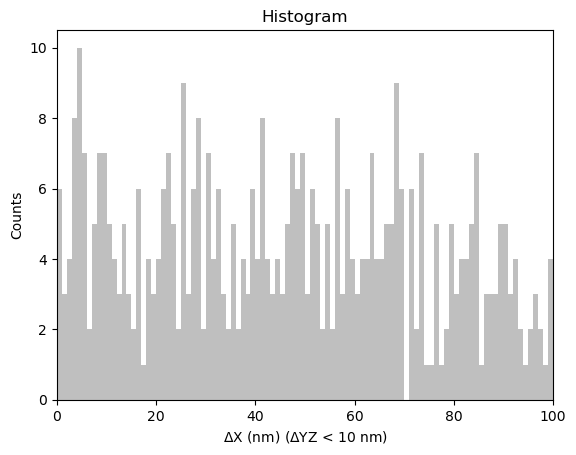

In [10]:
hist_values, bin_edges = zdisk_plots.plot_distance_hist(
    axial_distances,
    fitlength
    )
bin_centres = (bin_edges[0:(len(bin_edges) - 1)] + bin_edges[1:]) / 2

## Get the KDE data (estimate every 1 nm)

In [ ]:
kde_x_values, kde = zdisk_plots.plot_distance_kde(
    axial_distances,
    meos_precision,
    fitlength
    )

## Set the X-distances at which to calculate the axial RPD

In [11]:
calculation_points = np.arange(fitlength + 1.)

## Calculate the axial RPD with smoothing for Churchman 1D function

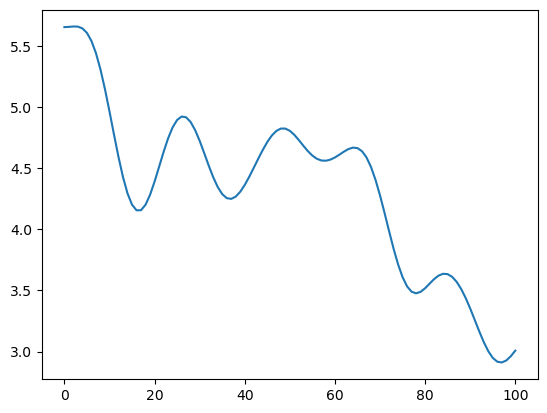

In [21]:
axial_rpd = plotting.estimate_rpd_churchman_1d(
    input_distances=axial_distances,
    calculation_points=calculation_points,
    # combined_precision=6.
    combined_precision=(np.sqrt(2) * meos_precision)
)
plt.plot(calculation_points, axial_rpd)

## Choose axial model

In [22]:
axial_model_with_info = zdisk_modelling.set_up_model_5_variable_peaks_after_offset_flat_bg_with_fit_settings()

## Fit model to Churchman-smoothed RPD

In [23]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    calculation_points,
    axial_rpd,
    axial_model_with_info.model_rpd,
    axial_model_with_info.initial_params,
    axial_model_with_info.param_bounds,
    )
print('')
print('Initial parameter guesses:')
print(axial_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(axial_model_with_info.param_bounds)

[[4.40950763e+01 6.37647681e+01]
 [2.00000000e+01 2.35304253e+02]
 [1.00000000e+01 1.32015382e+02]
 [4.85740343e+01 3.72436888e+03]
 [8.80320177e+01 6.14909163e+03]
 [4.45850825e-10 4.36498021e+03]
 [4.17380445e-04 9.61877260e+03]
 [1.33886800e-05 9.45473329e+05]
 [6.43696471e+01 3.27517867e-08]
 [4.31350879e+00 1.59635710e+00]
 [8.70670351e+00 8.85333749e+00]
 [2.87970569e+00 1.22227696e+02]]
SSR = 4.347105737560372
AIC = -291.7066343278639
AICcorr = -287.5227262818869

Initial parameter guesses:
[20, 5, 0, 1, 1, 1, 1, 1, 1, 3, 1, 20]

Parameter bounds:
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [50, 20, 10.0, 1000, 1000, 1000, 1000, 1000.0, 10000.0, 20, 1000, 100])


x at zero bg is -0.161775196480106.


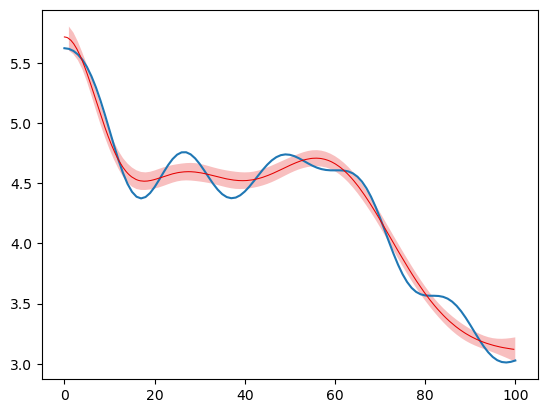

In [20]:
plt.plot(calculation_points, axial_rpd)
zdisk_plots.plot_fitted_model(
    axial_distances,
    fitlength,
    params_optimised,
    params_covar,
    axial_model_with_info,
    plot_95ci=True
    )

## Plot including histogram


lin_repeat_after_offset_5_flat_bg_replocs
________________________________
[[4.40945827e+01 6.64600675e+01]
 [2.00000000e+01 2.42603343e+02]
 [1.00000000e+01 1.37333475e+02]
 [4.85792560e+01 3.84814010e+03]
 [8.80807819e+01 6.35023213e+03]
 [5.92480335e-07 4.51148201e+03]
 [4.64786204e-05 9.87494791e+03]
 [7.36965925e-02 9.61742754e+05]
 [2.16169483e+01 2.17921879e-07]
 [4.28410833e+00 1.58622619e+00]
 [8.79648567e+00 8.80524476e+00]
 [2.87896637e+00 1.26264427e+02]]
SSR = 4.332809187147705
AIC = -287.8954081322598
AICcorr = -283.6628499927249


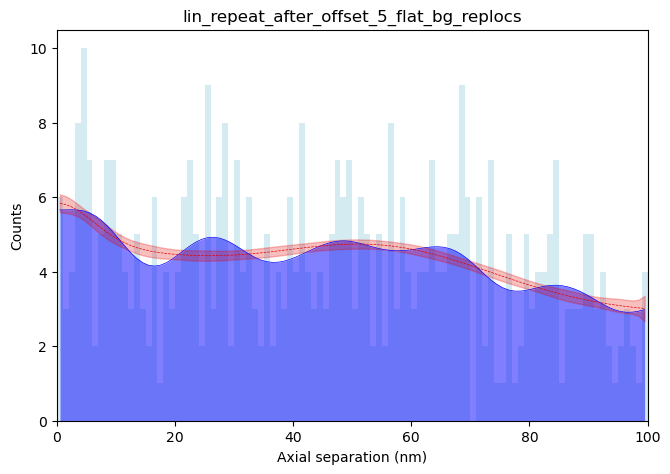

In [3]:
zdisk_plots.lasp_mEos_plot()